Note: this notebook is supposed to be only for training logic demonstration as the data is not a part of the repository.

# OCR задача

## Приготовления и импорт библиотек

In [1]:
import json
import os
import time
from collections import defaultdict
from string import digits

import cv2
import fastwer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from sklearn.model_selection import KFold, ParameterGrid
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from torch.nn.functional import ctc_loss, log_softmax
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

### Устройство исполнения

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

device(type='cpu')

## Работа с данными

### Создание train config

In [ ]:
path = "./data/train/ann"
path_img = "./data/train/img"

files = os.listdir(path)

config = []
for f in files:
    with open(os.path.join(path, f), "r") as json_config:
        temp = json.load(json_config)
        config.extend(
            [
                {
                    "file": os.path.join(path_img, temp["name"] + ".png"),
                    "text": temp["description"],
                }
            ]
        )

In [ ]:
print("Total number in train:", len(config))
print("First 3 items")
for item in config[:3]:
    print(item)

Total number in train: 49382
First 3 items
{'file': './data/train/img/A110AA47.png', 'text': 'A110AA47'}
{'file': './data/train/img/H278HH37.png', 'text': 'H278HH37'}
{'file': './data/train/img/K350BE46_0.png', 'text': 'K350BE46'}


### Создание test config

In [ ]:
path = "./data/test/ann"
path_img = "./data/test/img"

files = os.listdir(path)

test_config = []
for f in files:
    with open(os.path.join(path, f), "r") as json_config:
        temp = json.load(json_config)
        test_config.extend(
            [
                {
                    "file": os.path.join(path_img, temp["name"] + ".png"),
                    "text": temp["description"],
                }
            ]
        )

In [ ]:
len(test_config)

2845

###  Отображение данных

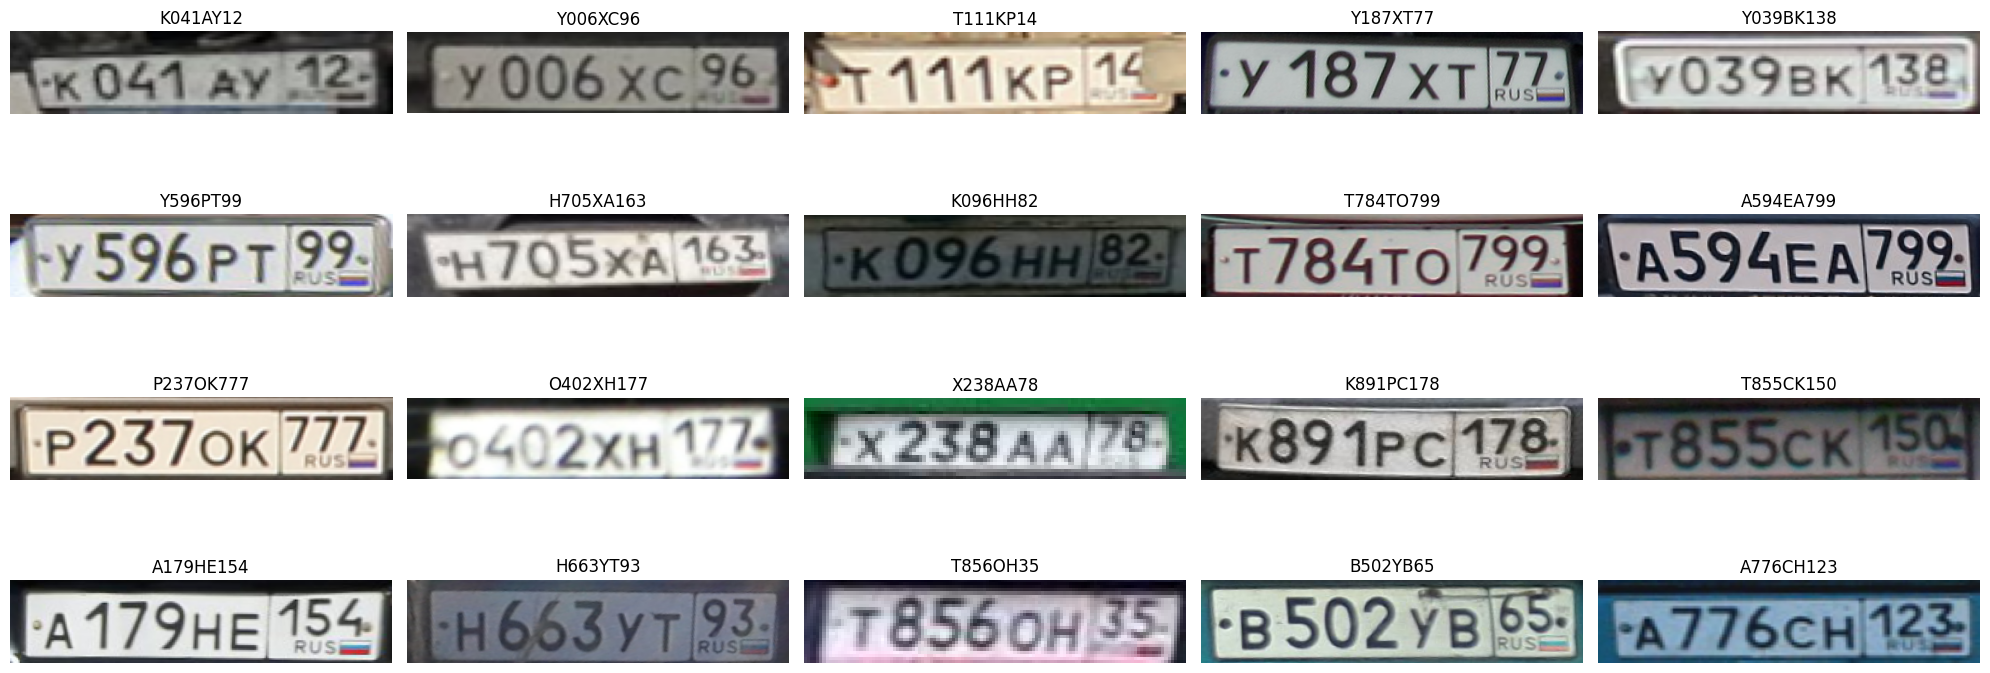

In [ ]:
sample_size = 20
cols = 5
rows = sample_size // cols + int(sample_size % cols != 0)

# Taking some random images
random_idxs = np.random.choice(len(config), size=sample_size, replace=False)

plt.figure(figsize=(20, 2 * rows))
for i, idx in enumerate(random_idxs, start=1):
    item = config[idx]
    text = item["text"]
    # load image from file
    image = cv2.imread(item["file"])

    # index of plt.subplot starts from 1 -> start=1
    plt.subplot(rows, cols, i)

    # flip third dimension as open-cv uses BGR convention
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Предобработка данных

In [ ]:
print(digits)

0123456789


Определим допустимый словарь: 12 символов в серии.

In [ ]:
symbols = "ABEKMHOPCTYX"
vocab = digits + symbols
print(vocab)

0123456789ABEKMHOPCTYX


Проверим, что в датасете стандарт номеров один для всех, заодно проверим, нет ли опечаток в  разметке, когда присутствуют буквы не из допустимого словаря (другие возможные опечатки проверить для такого мощного набора данных не представляется возможным).

In [ ]:
# mask = 'SNNNSSNN' or 'SNNNSSNNN'
def compute_mask(text):
    global count
    res = ""
    for char in text:
        if char.isdigit():
            res += "N"
        elif char.isalpha() and char in symbols:
            res += "S"
    if res == "SNNNSSNN" or res == "SNNNSSNNN":
        count += 1


count = 0
for item in config:
    compute_mask(item["text"])

print(count == len(config))

True


В датасете нет особых номеров, только один "нормальный" формат, в разметке все ок.

## Создание датасета

Реализация класса датасета. 

В рамках решения OCR задачи модель на стадии обучения на входе должна получать батч, айтемы которого обязательно включают:
- Изображение, причем каждое одинаковой, фиксированной длины и ширины, как того требует батч (за это будет отвечать атрибут resizing) 
- Закодированная ground-truth номерная последовательность и ее длина (последнее для CTC loss)

Хранить все будем в словаре.

In [ ]:
class SeqRecDataset(torch.utils.data.Dataset):
    def __init__(self, config, vocabulary=vocab, resizing=None):
        super(SeqRecDataset, self).__init__()
        self.config = config
        self.vocabulary = vocab
        self.image_names, self.texts = self.extract_data()
        self.resizing = resizing

    def extract_data(self):
        image_names, texts = [], []
        for item in self.config:
            image_names.append(item["file"])
            texts.append(item["text"])
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Convert and normalize to (0,1)
        image = cv2.imread(self.image_names[idx]).astype(np.float32) / 255.0
        text = self.texts[idx]
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        if self.resizing is not None:
            output = self.resizing(output)
        return output

    def text_to_seq(self, text):
        # Preserve 0 for blank
        seq = [self.vocabulary.find(c) + 1 for c in text]
        return seq

Согласно библиотеке OpenCV интерполяция методом INTER_AREA лучше всего подходит для сжатия, а INTER_LINEAR для увеличения изображения. В датасете достаточно большой разброс по размерам картинок, поэтому здесь мы произвели оценку глазами качества ресайза и интерполяции по рандомным подвыборкам, учитывая что соотношение сторон ~ 5 к 1 + так как мы планируем использовать ResNet 18 для генерации фичей, то необходима кратность 32. Самым оптимальным размером будет (320, 64) (выше - уже наверное нецелесообразно, так как нагрузка сильно повышается, меньше - сильное сокращение размерности по ширине, что плохо для предсказания текстовой последовательности). <br>
Разница между типами интерполяции изображения минимальна на глаз, поэтому не так важно, какую использовать.

In [ ]:
class Resize:
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, idx):
        idx["image"] = cv2.resize(
            idx["image"], dsize=self.size, interpolation=cv2.INTER_AREA
        )
        return idx

Формируем датасет для обучения `dataset`.

In [ ]:
resizing = Resize(size=(320, 64))
dataset = SeqRecDataset(config, vocabulary=vocab, resizing=resizing)

Взглянем на элемент датасета.

Image shape: (64, 320, 3)
Seq: [13, 1, 6, 1, 13, 20, 2, 7, 5]  |  Seq len: 9
Plate text: E050ET164


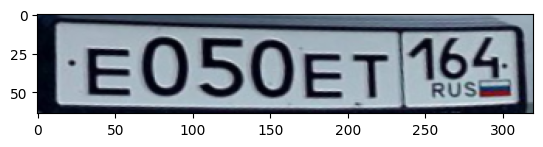

In [ ]:
x = dataset[666]
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], " | ", "Seq len:", x["seq_len"])
print("Plate text:", x["text"])

plt.imshow(x["image"][:, :, ::-1])
plt.show()

Сразу для torch.utils.data.DataLoader определим collate_fn, определяющий правило формирования склеивания элементов в батче  правильного размера (N, C, H, W).

In [ ]:
def collate_fn(batch):
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        # Convert to tensor and make RGB channel first dimension
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    # Concatenates along new dimension for images
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [ ]:
# Mini-test
data = [dataset[i] for i in range(5)]
m_batch = collate_fn(data)

print("Image shape:", m_batch["image"].shape)
print("Seq:", m_batch["seq"])
print("Seq len:", m_batch["seq_len"])
print("Plate text:", m_batch["text"])

Image shape: torch.Size([5, 3, 64, 320])
Seq: tensor([11,  2,  2,  1, 11, 11,  5,  8, 16,  3,  8,  9, 16, 16,  4,  8, 14,  4,
         6,  1, 12, 13,  5,  7, 12,  3, 10,  9, 20, 22,  2,  8,  9, 18,  6,  3,
         2, 22, 19, 10,  4], dtype=torch.int32)
Seq len: tensor([8, 8, 8, 9, 8], dtype=torch.int32)
Plate text: ['A110AA47', 'H278HH37', 'K350BE46', 'B298TX178', 'P521XC93']


Холдинг seq_len решает проблему неоднозначности длины номерной последовательности (8 или 9) при склейкe seq's в батче.

## Построение модели

CRNN модель состоит из двух частей: для извлечения признаков используется CNN-сеть (в качестве предобученной модели будем использовать ResNet), а для решения задачи распознавания символьной последовательности RNN-сеть (в качестве модели воспользуемся LSTM).

Структура ResNet 18:

In [ ]:
resnet = torchvision.models.resnet18(pretrained=False)
for layer in resnet.children():
    print(layer)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [ ]:
print(
    "Число фичей на выходе полносверточной части ResNet 18:",
    list(resnet.children())[:-2][-1][-1].bn2.num_features,
)

Число фичей на выходе полносверточной части ResNet 18: 512


Два последних слоя будут не нужны. Батч размера (N, C, H, W) после прохода всех сверточных слоев станет размера (N, 512, H // 32, W // 32) -> (N, 512, 2, 10). Применив слой пулинга с усреднением по высоте будем иметь (N, 512, 1, 10).

Для нашего случая ширина на выходе 10. Однако, так как нам нужно предсказывать символ blank для разделения одинаковых, но различных символов, то тогда для номерной последовательности в 9 символов (A000AA777) на самом деле необходимо предсказать 18 токенов (_A_0_0_0_A_A_7_7_7), т. е. нам необходима на выходе, как минимум, ширина W=18. Для этого увеличим размерность, используя свертку (1x1).

In [ ]:
class FeatureExtractor(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, input_size=(64, 320), output_len=18):
        super(FeatureExtractor, self).__init__()
        h, w = input_size
        resnet = torchvision.models.resnet18(
            weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        )

        self.cnn = torch.nn.Sequential(*list(resnet.children())[:-2])
        self.pool = torch.nn.AvgPool2d(kernel_size=(h // 32, 1))
        self.proj = torch.nn.Conv2d(w // 32, output_len, kernel_size=1)
        # save input_size for rnn
        self.num_output_features = list(resnet.children())[:-2][-1][-1].bn2.num_features

    def apply_projection(self, x):
        x = x.permute(0, 3, 2, 1).contiguous()  # to (N, W, H, C)
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()  # to (N, H, C, W)
        return x

    def forward(self, x):
        features = self.cnn(x)
        features = self.pool(features)
        features = self.apply_projection(features)
        return features

Протестируем данную часть модели.

In [ ]:
feature_extractor = FeatureExtractor()
x = torch.randn(5, 3, 64, 320)  # (N, C, H, W)
y = feature_extractor(x)
assert y.size() == (5, 1, 512, 18)

In [ ]:
feature_extractor.num_output_features

512

Перейдем к реализации реккурентной сети. <br>
LSTM на вход принимает батч размера (N, L, Hin) [batch_first = True], на выходе feature_extractor (N, C=1, Hin, L), поэтому необходимо произвести преобразование. Более никаких особенностей в модели.

In [ ]:
class SequencePredictor(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(
        self, input_size, hidden_size, num_layers, num_classes, dropout, bidirectional
    ):
        super(SequencePredictor, self).__init__()

        self.rnn = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=True,
        )

        fc_in = hidden_size * (1 + int(bidirectional))
        self.fc = torch.nn.Linear(in_features=fc_in, out_features=num_classes)

    def forward(self, x):
        # Make permutation
        x = x.squeeze(dim=1).permute(0, 2, 1)
        output, _ = self.rnn(x)
        output = self.fc(output)
        return output

Протестируем данную часть модели.

In [ ]:
seq_pred = SequencePredictor(
    input_size=512,
    hidden_size=128,
    num_layers=3,
    num_classes=len(vocab) + 1,
    dropout=0.0,
    bidirectional=False,
)

In [ ]:
x = torch.randn(5, 1, 512, 18)
y = seq_pred(x)
assert y.size() == (5, 18, 23)

Собираем все воедино.

In [ ]:
class CRNN(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(
        self,
        hidden_size=128,
        num_layers=2,
        dropout=0.3,
        bidirectional=True,
        vocabulary=vocab,
        cnn_input_size=(64, 320),
        output_len=18,
    ):
        super(CRNN, self).__init__()

        self.vocabulary = vocabulary
        self.fts_extr = FeatureExtractor(
            input_size=cnn_input_size, output_len=output_len
        )
        self.seq_pred = SequencePredictor(
            input_size=self.fts_extr.num_output_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            num_classes=len(vocabulary) + 1,
            dropout=dropout,
            bidirectional=bidirectional,
        )

    def forward(self, x):
        features = self.fts_extr(x)
        seq = self.seq_pred(features)
        return seq

Сразу инициализируем модель с дефолтными параметрами для обучения.

In [ ]:
crnn = CRNN()
_ = crnn.to(device)

Заключительный тест.

In [ ]:
x = torch.randn(5, 3, 64, 320).to(device)
y = crnn(x)
assert y.size() == (5, 18, 23)

Таким образом на выходе для каждого вектора-токена последовательности имеем оценку принадлежности к каждому классу.

## Код для обучения

 Напоминание о содержимом батча

In [ ]:
data = [dataset[i] for i in range(5)]
m_batch = collate_fn(data)

print("Image shape:", m_batch["image"].shape)
print("Seq:", m_batch["seq"])
print("Seq len:", m_batch["seq_len"])
print("Plate text:", m_batch["text"])

Image shape: torch.Size([5, 3, 64, 320])
Seq: tensor([11,  2,  2,  1, 11, 11,  5,  8, 16,  3,  8,  9, 16, 16,  4,  8, 14,  4,
         6,  1, 12, 13,  5,  7, 12,  3, 10,  9, 20, 22,  2,  8,  9, 18,  6,  3,
         2, 22, 19, 10,  4], dtype=torch.int32)
Seq len: tensor([8, 8, 8, 9, 8], dtype=torch.int32)
Plate text: ['A110AA47', 'H278HH37', 'K350BE46', 'B298TX178', 'P521XC93']


In [ ]:
def train_on_batch(model, batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()

    images = batch["image"].to(device)
    seqs = batch["seq"]
    seqs_len = batch["seq_len"]

    output = model(images).to("cpu")  # Size (N, T, C)
    log_probs = log_softmax(output, dim=-1)  # As input for CTC loss
    # Creating tensor consisted of input lengths
    seqs_len_pred = torch.Tensor([output.size(1)] * output.size(0)).int()

    loss = loss_function(
        log_probs=log_probs.transpose(0, 1),  # (T, N, C)
        targets=seqs,  # sum(target_lens)
        input_lengths=seqs_len_pred,  # (N)
        target_lengths=seqs_len,
    )  # (N)

    loss.backward()
    optimizer.step()

    # Return loss as float value
    return loss.cpu().item()

In [ ]:
def train_epoch(train_generator, model, loss_function, optimizer, callback=None):
    epoch_loss = 0
    total = 0
    for it, batch in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch, optimizer, loss_function)

        if callback is not None:
            model.eval()
            with torch.no_grad():
                callback(model, batch_loss)

        # Compute normalized loss per batch
        epoch_loss += batch_loss * len(batch["image"])
        total += len(batch["image"])

    return epoch_loss / total

In [ ]:
def trainer(
    count_of_epoch,
    batch_size,
    dataset,
    vocabulary,
    model,
    loss_function,
    optimizer,
    lr,
    weight_decay,
    sampler=None,
    collate_fn=collate_fn,
    callback=None,
):

    optima = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)
    iterations = tqdm(range(count_of_epoch), desc="epoch")
    iterations.set_postfix({"train epoch loss": np.nan})

    for it in iterations:
        # Set params for using multi-process loading
        batch_generator = tqdm(
            torch.utils.data.DataLoader(
                dataset=dataset,
                batch_size=batch_size,
                shuffle=sampler is None,
                num_workers=2,
                pin_memory=True,
                collate_fn=collate_fn,
                sampler=sampler,
            ),
            leave=False,
            total=len(dataset) // batch_size + (len(dataset) % batch_size > 0),
        )

        epoch_loss = train_epoch(
            train_generator=batch_generator,
            model=model,
            loss_function=loss_function,
            optimizer=optima,
            callback=callback,
        )

        iterations.set_postfix({"train epoch loss": epoch_loss})

### + Код для отслеживания результатов обучения

In [ ]:
class callback:
    def __init__(
        self,
        writer,
        dataset,
        loss_function,
        delimeter=20,
        batch_size=64,
        collate_fn=collate_fn,
    ):
        self.step = 0
        self.writer = writer
        self.dataset = dataset
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.collate_fn = collate_fn

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar("LOSS/train", loss, self.step)

        if self.step % self.delimeter == 0:

            batch_generator = torch.utils.data.DataLoader(
                dataset=self.dataset,
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=2,
                pin_memory=True,
                collate_fn=self.collate_fn,
                sampler=None,
            )

            test_loss = 0
            for it, batch in enumerate(batch_generator):
                images = batch["image"].to(device)
                seqs = batch["seq"]
                seqs_len = batch["seq_len"]
                plates_gt = batch["text"]

                output = model(images).cpu()
                log_probs = log_softmax(output, dim=-1)
                seqs_len_pred = torch.Tensor([output.size(1)] * output.size(0)).int()

                loss = self.loss_function(
                    log_probs=log_probs.transpose(0, 1),
                    targets=seqs,
                    input_lengths=seqs_len_pred,
                    target_lengths=seqs_len,
                )

                test_loss += loss.cpu().item() * len(images)

            test_loss /= len(self.dataset)
            self.writer.add_scalar("LOSS/test", test_loss, self.step)

    def __call__(self, model, loss):
        return self.forward(model, loss)

##  Обучение модели

In [ ]:
optimizer = torch.optim.Adam
loss_function = ctc_loss

In [ ]:
dataset_test = SeqRecDataset(test_config, resizing=Resize())

In [ ]:
writer = SummaryWriter(log_dir="training")
call = callback(writer, dataset_test, loss_function)

In [ ]:
trainer(
    count_of_epoch=20,
    batch_size=64,
    dataset=dataset,
    vocabulary=vocab,
    model=crnn,
    loss_function=loss_function,
    optimizer=optimizer,
    lr=1e-3,
    weight_decay=1e-4,
    callback=call,
)

In [3]:
event_acc = EventAccumulator("./board_loss/experiment")
event_acc.Reload()

_, step_nums_1, vals_1 = zip(*event_acc.Scalars('LOSS/train'))
_, step_nums_2, vals_2 = zip(*event_acc.Scalars('LOSS/test'))

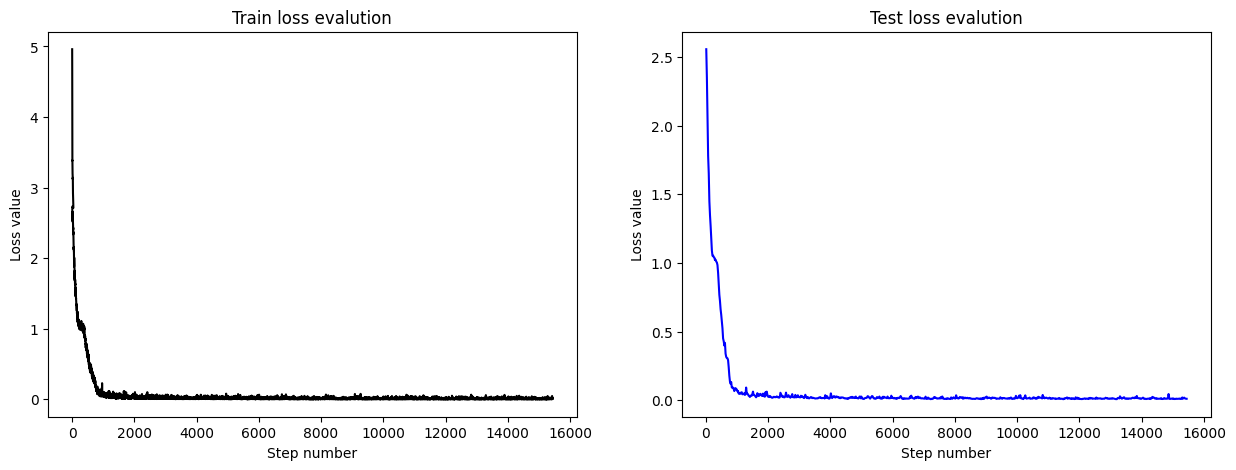

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

ax1.plot(step_nums_1, vals_1, color="k")

ax1.set_title("Train loss evalution")
ax1.set_ylabel("Loss value")
ax1.set_xlabel("Step number")

ax2.plot(step_nums_2, vals_2, color="b")

ax2.set_title("Test loss evalution")
ax2.set_ylabel("Loss value")
ax2.set_xlabel("Step number")
plt.show()

Лосс стабильно падает на протяжении всего обучения.

Сохраним веса модели.

In [ ]:
# with open('crnn_20_epochs', 'wb') as f:
#     torch.save(crnn.state_dict(), f)

Загрузка весов.

In [ ]:
with open("crnn_20_epochs", "rb") as f:
    state_dict = torch.load(f, map_location=device)
crnn.load_state_dict(state_dict, strict=False)
crnn.to(device)

## Полезный код для оценки модели

Реализуем функцию конвертации предсказания модели в номерную последовательность,  чтобы была возможность сравнивать предсказание с ground-truth и реализовать вычисление метрики CER.

In [ ]:
idx_to_char = dict(zip(range(1, 23), vocab))
idx_to_char[0] = "blank"

In [ ]:
def reverse_tokenizer(pred_seq, idx_to_char):
    seq = []  # Consists of blanks
    for i in range(len(pred_seq)):
        # Define predicted class in indexed form
        label_idx = np.argmax(pred_seq[i])
        # Convert to char
        seq.append(idx_to_char[label_idx])
    out = []  # Consists of no blanks
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != "blank":
                out.append(seq[i])
        else:
            if seq[i] != "blank" and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = "".join(out)
    return out


def decode(model_output, idx_to_char):
    model_output = model_output.to("cpu").numpy()
    plates_text = []
    for i in range(len(model_output)):
        plates_text.append(reverse_tokenizer(model_output[i], idx_to_char))
    return plates_text

Выполним тест для случайного тензора и случайных весов в модели.

In [ ]:
# Mini-test
y.shape

torch.Size([5, 18, 23])

In [ ]:
decode(y, vocab)

['6PCP7BP3B3B', '7P0P7M7P37', 'Y7Y7B70', '7BP7B7M', 'P737Y7P17']

Ground-truth последовательности хранятся в батче в виде списка. Таким образом, можно легко реализовать вычисление метрики CER. Для этого воспользуемся библиотекой FastWER. <br>
Пример работы:

In [ ]:
test111 = ["C423CO197"] * 64
test222 = ["O423CO177"] * 64
count = 0
for i in range(64):
    count += fastwer.score_sent(test111[i], test222[i], char_level=True)
print(count / 64)

22.222199999999994


Определим функцию финальной оценки модели (будем так же считать долю верно предсказанных номеров целиком).

In [ ]:
def testing(
    batch_size,
    dataset,
    vocabulary,
    model,
    loss_function,
    sampler=None,
    collate_fn=collate_fn,
):

    batch_generator = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        collate_fn=collate_fn,
        sampler=sampler,
    )

    test_losses, cers = [], []
    acc = 0
    model.eval()

    for it, batch in enumerate(batch_generator):
        images = batch["image"].to(device)
        seqs = batch["seq"]
        seqs_len = batch["seq_len"]
        plates_gt = batch["text"]

        with torch.no_grad():
            output = model(images).cpu()
        log_probs = log_softmax(output, dim=-1)
        seqs_len_pred = torch.Tensor([output.size(1)] * output.size(0)).int()

        loss = loss_function(
            log_probs=log_probs.transpose(0, 1),
            targets=seqs,
            input_lengths=seqs_len_pred,
            target_lengths=seqs_len,
        )

        test_losses.append(loss.cpu().item())

        # CER evaluation
        cer = 0
        this_batch_size = len(images)
        plates_pred = decode(output, vocabulary)

        for i in range(this_batch_size):
            cer += fastwer.score_sent(plates_pred[i], plates_gt[i], char_level=True)
            acc += plates_pred[i] == plates_gt[i]
        cer /= this_batch_size

        cers.append(cer)
    return np.mean(test_losses), np.mean(cers), acc / len(dataset)

## Финальная оценка качества модели

In [ ]:
loss_function = ctc_loss

In [ ]:
avg_ctcloss, avg_cer, acc = testing(
    batch_size=64,
    dataset=dataset_test,
    vocabulary=vocab,
    model=crnn,
    loss_function=loss_function,
)

In [ ]:
print(f"Average CTCLoss: {avg_ctcloss:.5f}")
print(f"Average CER: {avg_cer:.2f} %")
print(f"General accuracy: {100 * acc:.2f} %")

Average CTCLoss: 0.00994
Average CER: 0.22 %
General accuracy: 98.59 %


Метрики отличные.

## Валидация: тюнинг гиперпараметров модели

ПРИМЕЧАНИЕ: Код работает, но это чертовски долго (для валидации нейронных сетей рекомендовали изучить библиотеку Ray, поэтому наверное бессмысленно здесь использовать `ParameterGrid`). <br>
Причем стоит отметить, что были попытки отдельного обучения моделей с другими параметрами (большее число слоев и большая размерность скрытого слоя), но качество было хуже, как на трейне, так и на тесте, т.е. скорее всего такая модель хуже настраивается. <br>
Поэтому, возможно, с учетом хорошего результата основной модели на тесте, упущение в отсутствие валидации не такое значительное.

Гиперпараметры, которые нужно подобрать:
- num_layers
- hidden_dim
- dropout
- bidirectional

У нас имеется 3 набора данных.  Воспользуемся таким подходом: training data будет разбиваться на фолды. Затем по лучшему усредненному CTCLoss на контрольных выборках будем проверять, что на test data CTCLoss среди всех моделей также минимальный. В качестве последней проверки обобщающая способность выбранной лучшей модели будет протестирована на validation data: минимальное отклонение в значениях CTCLoss будет свидетельствовать об успехе.

In [ ]:
cross_val = KFold(n_splits=3)
number_of_batch = cross_val.get_n_splits(dataset_test)

grid = ParameterGrid(
    {
        "num_layers": [2, 3, 5],
        "hidden_size": [128, 256],
        "dropout": [0.3, 0.5],
        "bidirectional": [True, False],
    }
)

In [ ]:
scores = defaultdict(list)
for item in tqdm(grid):
    ctc_scores, cer_scores, acc_scores = [], [], []
    for train_idxs, test_idxs in tqdm(
        cross_val.split(dataset), total=number_of_batch, leave=False
    ):

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idxs)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idxs)

        crnn_ht = CRNN(
            num_layers=item["num_layers"],
            hidden_size=item["hidden_size"],
            dropout=item["dropout"],
            bidirectional=item["bidirectional"],
        )

        crnn_ht.to(device)

        trainer(
            count_of_epoch=10,
            batch_size=64,
            dataset=dataset,
            vocabulary=vocab,
            model=crnn_ht,
            loss_function=loss_function,
            optimizer=optimizer,
            lr=1e-3,
            weight_decay=1e-4,
            sampler=train_subsampler,
        )

        avg_ctcloss, avg_cer, acc = testing(
            batch_size=64,
            dataset=dataset,
            vocabulary=vocab,
            model=crnn_ht,
            loss_function=loss_function,
            sampler=test_subsampler,
        )

        ctc_scores.append(avg_ctcloss)
        cer_scores.append(avg_cer)
        acc_scores.append(acc)

    scores[str(item)] = [np.mean(ctc_scores), np.mean(cer_scores), np.mean(acc_scores)]

In [ ]:
scores

## Оценка эффективности инференса модели

Для наглядного примера возьмем кропы номеров, где номера "в лоб" (с такими модель справляется на ура, согласно результатам оценки модели) и где под углом.

In [ ]:
images_path = [
    "./test_image1.jpg",
    "./test_image2.jpg",
    "./test_image3.png",
    "./test_image4.jpg",
]
gt_plates = ["O007OO77", "M938OX116", "A096TC150", "E926BY152"]

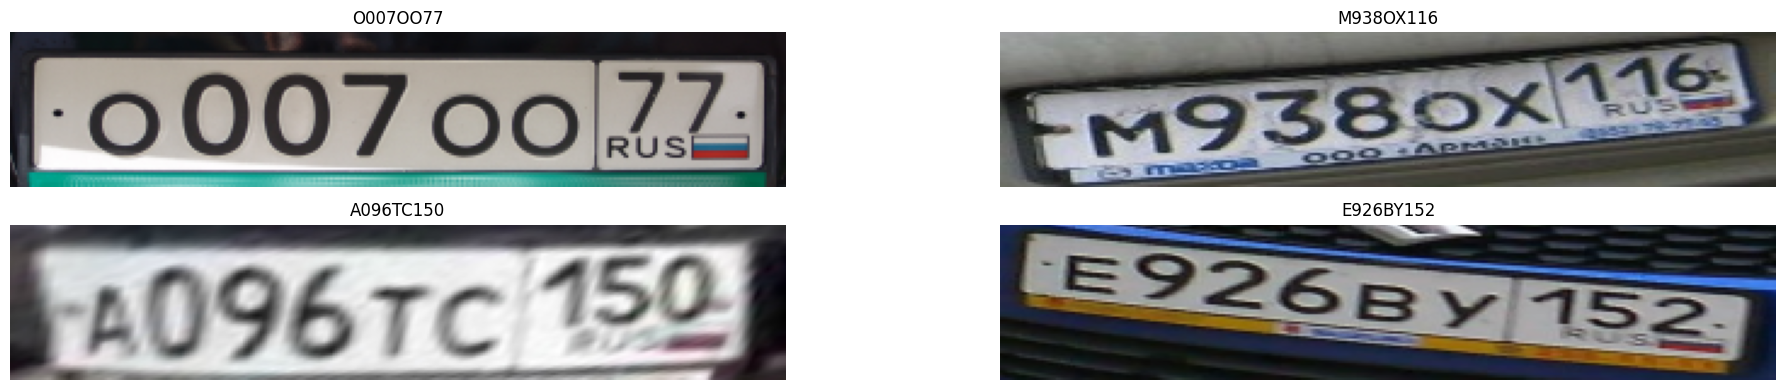

In [ ]:
sample_size = 4
cols = 2
rows = sample_size // cols + int(sample_size % cols != 0)

plt.figure(figsize=(20, 2 * rows))
for i, image in enumerate(images_path, start=1):
    image = cv2.imread(image).astype(np.float32) / 255.0
    image = cv2.resize(image, dsize=(320, 64), interpolation=cv2.INTER_AREA)

    plt.subplot(rows, cols, i)

    plt.imshow(image[:, :, ::-1])
    plt.title(gt_plates[i - 1])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def check_inference_time(images_path, gt_plates, debug=True):
    for i, image in enumerate(images_path):
        since = time.time()
        image = cv2.imread(image).astype(np.float32) / 255.0
        image = cv2.resize(image, dsize=(320, 64), interpolation=cv2.INTER_AREA)
        data = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device)

        output = crnn(data)
        plates_pred = decode(output, vocab)
        print("Predicted plate", plates_pred[0])
        print("Ground-truth plate", gt_plates[i])

        if debug:
            print(
                "Model inference in {:2.3f} seconds".format(time.time() - since),
                end="\n" * 2,
            )
            # image = cv2.resize(image, (0, 0), fx = 1, fy = 1, interpolation=cv2.INTER_CUBIC)

In [ ]:
check_inference_time(images_path, gt_plates)

Predicted plate O007OO77
Ground-truth plate O007OO77
Model inference in 0.554 seconds

Predicted plate M938OO109
Ground-truth plate M938OX116
Model inference in 0.512 seconds

Predicted plate A096TC150
Ground-truth plate A096TC150
Model inference in 0.522 seconds

Predicted plate B926XX152
Ground-truth plate E926BY152
Model inference in 0.511 seconds



Видно, что из-за специфичной архитектуры модели + обучению на датасете, состоящем только из кропнутых номеров "в лоб", она плохо справляется с номерами, которые сильно под углом, это вполне ожидаемо. <br>
Причем цифры, которые побольше букв, в целом модель распознает лучше.

Идеи, как повысить качество распознавания:
- Сделать преобразования, выпрямляющие номер. Качество распознавания определенно улучшится
- Обучаться на датасете номеров, кропнутых моделью детекции, где будет полное разнообразие углов и соответственно как бы больше шума. Возможно, CRNN сможет лучше подстраиваться под такие объекты, и качество распознавания также улучшится, однако оно в среднем станет хуже.